<a href="https://colab.research.google.com/github/lajaaiti/Alto_MVC_POO/blob/main/testElvis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [2]:
# data import
data = pd.read_csv('dfElvis.csv')
data.head()

,Titre,Lyric
0,Can't Help Falling In Love,"Wise men say, only fools rush in\nBut I can't ..."
1,Suspicious Minds,We're caught in a trap\nI can't walk out\nBeca...
2,Always On My Mind,"Maybe I didn't treat you,\nQuite as good as I ..."
3,Love Me Tender,"Love me tender, love me sweet,\nNever let me g..."
4,My Way,And now the end is near\nAnd so I face the fin...


In [3]:
data['Number_of_words'] = data['Lyric'].apply(lambda x:len(str(x).split()))
data.head()

,Titre,Lyric,Number_of_words
0,Can't Help Falling In Love,"Wise men say, only fools rush in\nBut I can't ...",110
1,Suspicious Minds,We're caught in a trap\nI can't walk out\nBeca...,203
2,Always On My Mind,"Maybe I didn't treat you,\nQuite as good as I ...",159
3,Love Me Tender,"Love me tender, love me sweet,\nNever let me g...",125
4,My Way,And now the end is near\nAnd so I face the fin...,249


In [4]:
data['Number_of_words'].describe()

count    747.000000
mean     154.759036
std       66.081887
min       17.000000
25%      106.000000
50%      149.000000
75%      192.000000
max      452.000000
Name: Number_of_words, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

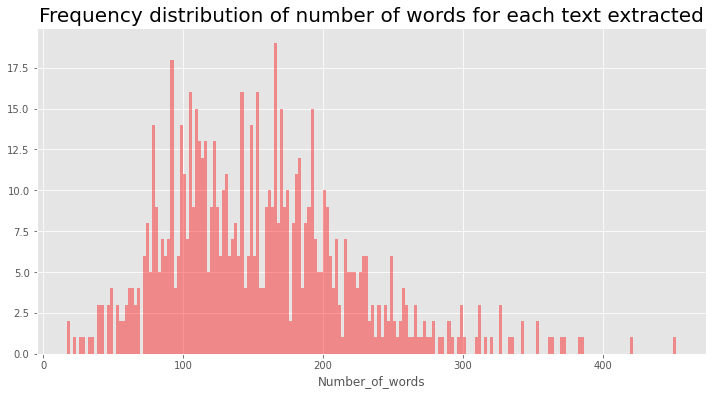

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [6]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(data['Lyric'].astype(str))
tokenized_sentences[0]

[434,
 646,
 74,
 99,
 1358,
 983,
 9,
 24,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 299,
 2,
 176,
 123,
 16,
 13,
 4,
 723,
 33,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 35,
 4,
 672,
 1670,
 673,
 6,
 1,
 317,
 177,
 22,
 16,
 390,
 2662,
 62,
 820,
 6,
 13,
 77,
 8,
 109,
 77,
 8,
 228,
 97,
 104,
 17,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 35,
 4,
 672,
 1670,
 673,
 6,
 1,
 317,
 177,
 22,
 16,
 390,
 2662,
 62,
 820,
 6,
 13,
 77,
 8,
 109,
 77,
 8,
 228,
 97,
 104,
 17,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 17,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3]

In [7]:
#Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [8]:
input_sequences[:10]

array([[  0,   0,   0, ...,   0, 434, 646],
       [  0,   0,   0, ..., 434, 646,  74],
       [  0,   0,   0, ..., 646,  74,  99],
       ...,
       [  0,   0,   0, ...,   9,  24,   2],
       [  0,   0,   0, ...,  24,   2,  67],
       [  0,   0,   0, ...,   2,  67, 231]], dtype=int32)

In [9]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [10]:
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(240)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=25, verbose=1, callbacks=[earlystop])

Epoch 1/25
3596/3596 [==============================] - 181s 48ms/step - loss: 5.9718 - accuracy: 0.0708
Epoch 2/25
3596/3596 [==============================] - 176s 49ms/step - loss: 5.1582 - accuracy: 0.1304
Epoch 3/25
3596/3596 [==============================] - 175s 49ms/step - loss: 4.5437 - accuracy: 0.1878
Epoch 4/25
3596/3596 [==============================] - 184s 51ms/step - loss: 4.0371 - accuracy: 0.2427
Epoch 5/25
3596/3596 [==============================] - 176s 49ms/step - loss: 3.6228 - accuracy: 0.2945
Epoch 6/25
3596/3596 [==============================] - 173s 48ms/step - loss: 3.2820 - accuracy: 0.3393
Epoch 7/25
3596/3596 [==============================] - 176s 49ms/step - loss: 2.9953 - accuracy: 0.3830
Epoch 8/25
3596/3596 [==============================] - 175s 49ms/step - loss: 2.7575 - accuracy: 0.4192
Epoch 9/25
3596/3596 [==============================] - 175s 49ms/step - loss: 2.5579 - accuracy: 0.4520
Epoch 10/25
3596/3596 [==============================] 

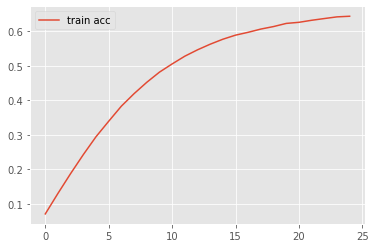

<Figure size 432x288 with 0 Axes>

In [11]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [12]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted =np.argmax(predicted,axis=1)
        #predicted = np.round(predicted).astype(int)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [13]:
complete_this_song("the sky is blue", 10)

"the sky is blue and you're so alone and i will never see you"

In [ ]:
# save model
model.save('Elvis_generator_text.h5')